# Tutorial VI: Recurrent Neural Networks

<p>
Bern Winter School on Machine Learning, 2021<br>
Prepared by Mykhailo Vladymyrov.
</p>

This work is licensed under a <a href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.

In this session we will see what RNN is. We will use it to predict/generate text sequence, but same approach can be applied to any sequential data.


So far we looked at the data available altogether. In many cases the data is sequential (weather, speach, sensor signals etc).
RNNs are specifically designed for such tasks.

<img src="https://github.com/neworldemancer/BMLWS/raw/main/figures/rnn.png" alt="drawing" width="90%"/><br>



## 1. Load necessary libraries

In [15]:
colab = True # set to True is using google colab

In [16]:
if colab:
    %tensorflow_version 2.x

In [17]:
import sys

import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipyd
import tensorflow as tf
import collections
import time

# We'll tell matplotlib to inline any drawn figures like so:
%matplotlib inline
plt.style.use('ggplot')

from IPython.core.display import HTML
HTML("""<style> .rendered_html code { 
    padding: 2px 5px;
    color: #0000aa;
    background-color: #cccccc;
} </style>""")

%load_ext tensorboard

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## unpack libraries
if using colab, run the next cell

In [18]:
if colab:
    p = tf.keras.utils.get_file('./material.tgz', 'https://github.com/neworldemancer/BMLWS/raw/main/tut_files/tpub0320.tgz')
    !mv {p} .
    !tar -xvzf material.tgz > /dev/null 2>&1

81223680/81207979 [==============================] - 1s 0us/step


In [19]:
from utils import gr_disp

In [20]:
def show_graph(g=None, gd=None):
    gr_disp.show_graph_eager(g, gd)
    %tensorboard --logdir logs

## 2. Load the text data

In [21]:
def read_data(fname):
    with open(fname) as f:
        content = f.readlines()
    content = [x.strip() for x in content]
    content = [word for i in range(len(content)) for word in content[i].split()]
    content = np.array(content)
    return content

In [22]:
training_file = 'RNN/rnn.txt'

In [23]:
training_data = read_data(training_file)

In [24]:
print(training_data[:100])

['recurrent' 'neural' 'networks' ',' 'or' 'rnns' '(' 'rumelhart' 'et' 'al'
 '.' ',' '1986a' ')' ',' 'are' 'a' 'family' 'of' 'neural' 'networks' 'for'
 'processing' 'sequential' 'data' '.' 'much' 'as' 'a' 'convolutional'
 'network' 'is' 'a' 'neural' 'network' 'that' 'is' 'specialized' 'for'
 'processing' 'a' 'grid' 'of' 'values' 'such' 'as' 'an' 'image' ',' 'a'
 'recurrent' 'neural' 'network' 'is' 'a' 'neural' 'network' 'that' 'is'
 'specialized' 'for' 'processing' 'a' 'sequence' 'of' 'values' 'x' '(' '1'
 ')' ',' '.' '.' '.' ',' 'x' '(' 'tau' ')' '.' 'just' 'as' 'convolutional'
 'networks' 'can' 'readily' 'scale' 'to' 'images' 'with' 'large' 'width'
 'and' 'height' ',' 'and' 'some' 'convolutional' 'networks' 'can']


## 3. Build dataset
We will assign an id to each word, and make dictionaries word->id and id->word.
The most frequently repeating words have lowest id

In [25]:
def build_dataset(words):
    count = collections.Counter(words).most_common()
    dictionary = {}
    for word, _ in count:
        dictionary[word] = len(dictionary)
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return dictionary, reverse_dictionary

In [26]:
dictionary, reverse_dictionary = build_dataset(training_data)
vocab_size = len(dictionary)

In [27]:
print(dictionary)

{'the': 0, '.': 1, ',': 2, 'of': 3, '(': 4, ')': 5, 'a': 6, 'to': 7, 'in': 8, 't': 9, 'is': 10, 'time': 11, '1': 12, 'sequence': 13, 'x': 14, 'that': 15, 'for': 16, 'as': 17, 'recurrent': 18, 'we': 19, 'network': 20, '10': 21, 'networks': 22, '-': 23, 'and': 24, 'neural': 25, 'can': 26, 'state': 27, 'with': 28, 'be': 29, 'each': 30, 'graph': 31, '2': 32, 'different': 33, 'this': 34, ';': 35, 'it': 36, 'at': 37, 'computational': 38, 'f': 39, 'such': 40, 'parameters': 41, 'across': 42, 'model': 43, 'equation': 44, 'h': 45, 'length': 46, 'function': 47, 'step': 48, 's': 49, '=': 50, 'an': 51, 'variable': 52, 'sharing': 53, 'information': 54, 'same': 55, 'on': 56, 'theta': 57, 'tau': 58, 'than': 59, 'one': 60, 'not': 61, 'input': 62, 'by': 63, 'steps': 64, 'use': 65, 'output': 66, 'unfolded': 67, 'would': 68, 'from': 69, 'lengths': 70, 'example': 71, 'two': 72, 'all': 73, 'way': 74, 'unfolding': 75, 'figure': 76, 'past': 77, 'g': 78, 'or': 79, 'rnns': 80, 'convolutional': 81, ':': 82, 'pos

Then the whole text will look as a sequence of word ids:

In [28]:
words_as_int = [dictionary[w] for w in training_data]
print(words_as_int)

[18, 25, 22, 2, 79, 80, 4, 242, 102, 103, 1, 2, 243, 5, 2, 244, 6, 245, 3, 25, 22, 16, 104, 246, 105, 1, 106, 17, 6, 81, 20, 10, 6, 25, 20, 15, 10, 144, 16, 104, 6, 247, 3, 107, 40, 17, 51, 248, 2, 6, 18, 25, 20, 10, 6, 25, 20, 15, 10, 144, 16, 104, 6, 13, 3, 107, 14, 4, 12, 5, 2, 1, 1, 1, 2, 14, 4, 58, 5, 1, 249, 17, 81, 22, 26, 250, 145, 7, 108, 28, 251, 252, 24, 253, 2, 24, 146, 81, 22, 26, 109, 108, 3, 52, 110, 2, 18, 22, 26, 145, 7, 106, 254, 111, 59, 68, 29, 255, 16, 22, 147, 13, 23, 256, 257, 1, 148, 18, 22, 26, 149, 109, 111, 3, 52, 46, 1, 7, 150, 69, 258, 22, 7, 18, 22, 2, 19, 112, 7, 259, 260, 3, 60, 3, 0, 261, 262, 263, 8, 151, 113, 24, 114, 264, 3, 265, 82, 53, 41, 42, 33, 152, 3, 6, 43, 1, 115, 53, 266, 36, 83, 7, 267, 24, 268, 0, 43, 7, 153, 3, 33, 269, 4, 33, 70, 2, 270, 5, 24, 154, 42, 271, 1, 84, 19, 272, 85, 41, 16, 30, 116, 3, 0, 11, 117, 2, 19, 273, 61, 154, 7, 13, 70, 61, 274, 275, 86, 2, 276, 118, 114, 277, 42, 33, 13, 70, 24, 42, 33, 155, 8, 11, 1, 40, 53, 10, 27

## 4. Build model

We will build the model in TF2.
It will contain an embedding layer, and three LSTM layers.
Dense layer on top is used to output probability of the next word:

In [29]:
# Parameters
n_input = 3  # word sequence to predict the following word

# number of units in RNN cells
n_hidden = [256, 512, 128]

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 128, input_length=n_input))

for layer_i, n_h in enumerate(n_hidden):
  model.add(tf.keras.layers.LSTM(n_h, return_sequences=True, name=f'{layer_i}_lstm{n_h}'))

model.add(tf.keras.layers.Dense(vocab_size, activation='softmax'))

model.compile(optimizer='RMSProp',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

W0 = model.get_weights()  # to reset model to original state:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 3, 128)            63104     
                                                                 
 0_lstm256 (LSTM)            (None, 3, 256)            394240    
                                                                 
 1_lstm512 (LSTM)            (None, 3, 512)            1574912   
                                                                 
 2_lstm128 (LSTM)            (None, 3, 128)            328192    
                                                                 
 dense (Dense)               (None, 3, 493)            63597     
                                                                 
Total params: 2,424,045
Trainable params: 2,424,045
Non-trainable params: 0
_________________________________________________________________


## 5. Data streaming

Here we will see how to feed a dataset for model training:

In [30]:
# create tf.data.Dataset object
word_dataset = tf.data.Dataset.from_tensor_slices(words_as_int)

In [31]:
# take metod generates elements:
for i in word_dataset.take(5):
  print(reverse_dictionary[i.numpy()])

recurrent
neural
networks
,
or


The `batch` method creates dataset, that generates sequences of elements:

In [32]:
sequences = word_dataset.batch(n_input+1, drop_remainder=True)

In [33]:
# helper for int-to-text conversion
to_text = lambda arr:' '.join([reverse_dictionary[it] for it in arr])

In [34]:
for item in sequences.take(5):
  print(to_text(item.numpy()))

recurrent neural networks ,
or rnns ( rumelhart
et al . ,
1986a ) , are
a family of neural


 The `map` method allows to use any function to preprocess the data:

In [35]:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]

    return input_text, target_text

dataset = sequences.map(split_input_target)

The model will predict input_text -> target_text:

In [36]:
for input_example, target_example in  dataset.take(1):
  print ('Input data: ', to_text(input_example.numpy()))
  print ('Target data:', to_text(target_example.numpy()))

Input data:  recurrent neural networks
Target data: neural networks ,


Finally we will shuffle the items, and produce minibatches of 16 elements:

In [37]:
dataset = dataset.shuffle(10000).batch(16, drop_remainder=True)
dataset

<BatchDataset shapes: ((16, 3), (16, 3)), types: (tf.int32, tf.int32)>

Let's test not trained model:

In [38]:
for input_example_batch, target_example_batch in dataset.take(1):
  example_batch_predictions = model(input_example_batch)
  print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(16, 3, 493) # (batch_size, sequence_length, vocab_size)


In [39]:
print('input: ', to_text(input_example_batch.numpy()[0]))
print('output:', to_text(target_example_batch.numpy()[0]))
print('pred:  ', to_text(example_batch_predictions.numpy()[0].argmax(axis=1)))


input:  ) . the
output: . the convolution
pred:   several several several


## 5. Train!

In [40]:
#model.set_weights(W0)
history = model.fit(dataset, epochs=200, verbose=1)

Epoch 1/200
33/33 [==============================] - 4s 7ms/step - loss: 5.7348 - accuracy: 0.0467
Epoch 2/200
33/33 [==============================] - 0s 7ms/step - loss: 5.2107 - accuracy: 0.0518
Epoch 3/200
33/33 [==============================] - 0s 7ms/step - loss: 5.0339 - accuracy: 0.0518
Epoch 4/200
33/33 [==============================] - 0s 7ms/step - loss: 4.8670 - accuracy: 0.0707
Epoch 5/200
33/33 [==============================] - 0s 7ms/step - loss: 4.7497 - accuracy: 0.0726
Epoch 6/200
33/33 [==============================] - 0s 7ms/step - loss: 4.6632 - accuracy: 0.0789
Epoch 7/200
33/33 [==============================] - 0s 8ms/step - loss: 4.5481 - accuracy: 0.1023
Epoch 8/200
33/33 [==============================] - 0s 7ms/step - loss: 4.4698 - accuracy: 0.1143
Epoch 9/200
33/33 [==============================] - 0s 7ms/step - loss: 4.3606 - accuracy: 0.1199
Epoch 10/200
33/33 [==============================] - 0s 7ms/step - loss: 4.2900 - accuracy: 0.1351
Epoch 11/

In [41]:
def draw_history(hist):
  fig, axs = plt.subplots(1, 2, figsize=(10,5))
  axs[0].plot(hist.epoch, hist.history['loss'])
  if 'val_loss' in hist.history:
    axs[0].plot(hist.epoch, hist.history['val_loss'])
  axs[0].legend(('training loss', 'validation loss'))
  axs[1].plot(hist.epoch, hist.history['accuracy'])
  if 'val_accuracy' in hist.history:
    axs[1].plot(hist.epoch, hist.history['val_accuracy'])

  axs[1].legend(('training accuracy', 'validation accuracy'))
  plt.show()

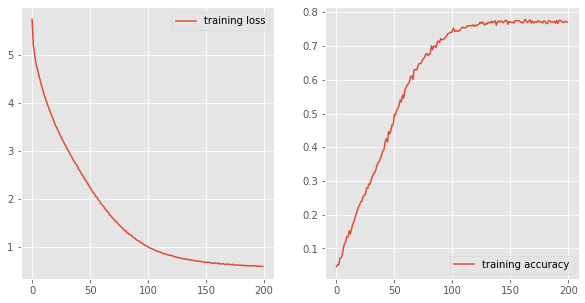

In [42]:
draw_history(history)

## 6. Generating text with RNN

Take word sequence and generate the following 128 words:

In [43]:
def gen_long(model, word_id_arr, n_words=128):
  out = []
  words = list(word_id_arr.copy())
  for i in range(n_words):
      keys = np.reshape(np.array(words), [-1, n_input])

      onehot_pred = model(keys).numpy()[0]
      pred_index = onehot_pred.argmax(axis=1)
      pred = pred_index[-1]
      out.append(pred)

      words = words[1:]
      words.append(pred)
  sentence = to_text(out)
  return sentence

In [44]:
for input_example_batch, target_example_batch in dataset.take(10):
  input_seq = input_example_batch.numpy()[0]
  sentence = gen_long(model, input_seq)
  print(to_text(input_seq), '...')
  print('\t...', sentence, '\n')

rnn is used ...
	... in equation , . . . x . 1 ) = x ( t ) ; theta , x ) ; theta , x ) ; theta , x ) ; theta , x ) ; theta , x ) ; theta , x ) ; theta , x ) ; theta , x ) ; theta , x ) ; theta , x ) ; theta , x ) ; theta , x ) ; theta , x ) ; theta , x ) ; theta , x ) ; theta , x ) ; theta , x ) ; theta , x ) ; theta , x ) ; theta , x ) ; theta , x ) ; theta , x ) ; theta , 

of the previous ...
	... members function , t t ; theta ) ; theta , x ) ; theta , x ) ; theta , x ) ; theta , x ) ; theta , x ) ; theta , x ) ; theta , x ) ; theta , x ) ; theta , x ) ; theta , x ) ; theta , x ) ; theta , x ) ; theta , x ) ; theta , x ) ; theta , x ) ; theta , x ) ; theta , x ) ; theta , x ) ; theta , x ) ; theta , x ) ; theta , x ) ; theta , x ) ; theta , x ) ; theta , x ) 

with a function ...
	... g to the go f . , . . . x . 1 ) = x ( t ) ; theta , x ) ; theta , x ) ; theta , x ) ; theta , x ) ; theta , x ) ; theta , x ) ; theta , x ) ; theta , x ) ; theta , x ) ; theta , x ) ; theta , x ) ; th

Or try to input some text and see continuation:

In [45]:
while True:
    prompt = "%s words: " % n_input

    try:
      sentence = input(prompt)
    except KeyboardInterrupt:
      break

    sentence = sentence.strip()
    words = sentence.split(' ')
    if len(words) != n_input:
        continue
    try:
        symbols_in_keys = [dictionary[str(words[i])] for i in range(len(words))]
    except:
        print("Word not in dictionary")
        continue

    sentence = gen_long(model, symbols_in_keys)
    print(sentence)


3 words: The network is
Word not in dictionary
3 words: the network is
the neural network is equation 10 . 4 or 10 ( t ) ; theta , x ) ; theta , x ) ; theta , x ) ; theta , x ) ; theta , x ) ; theta , x ) ; theta , x ) ; theta , x ) ; theta , x ) ; theta , x ) ; theta , x ) ; theta , x ) ; theta , x ) ; theta , x ) ; theta , x ) ; theta , x ) ; theta , x ) ; theta , x ) ; theta , x ) ; theta , x ) ; theta , x ) ; theta , x ) ; theta , x )
3 words: iteration text run
Word not in dictionary


## 7. Exercise 


* Run with 5-7 input words instead of 3.
* increase number of training iterations, since convergance will take much longer (training as well!).

In [46]:
# Parameters
n_input = 8  # word sequence to predict the following word

# number of units in RNN cells
n_hidden = [256, 512, 128]

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 128, input_length=n_input))

for layer_i, n_h in enumerate(n_hidden):
  model.add(tf.keras.layers.LSTM(n_h, return_sequences=True, name=f'{layer_i}_lstm{n_h}'))

model.add(tf.keras.layers.Dense(vocab_size, activation='softmax'))

model.compile(optimizer='RMSProp',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

W0 = model.get_weights()  # to reset model to original state:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 8, 128)            63104     
                                                                 
 0_lstm256 (LSTM)            (None, 8, 256)            394240    
                                                                 
 1_lstm512 (LSTM)            (None, 8, 512)            1574912   
                                                                 
 2_lstm128 (LSTM)            (None, 8, 128)            328192    
                                                                 
 dense_1 (Dense)             (None, 8, 493)            63597     
                                                                 
Total params: 2,424,045
Trainable params: 2,424,045
Non-trainable params: 0
_________________________________________________________________


In [47]:
dataset = dataset.shuffle(10000).batch(16, drop_remainder=True)
dataset

<BatchDataset shapes: ((16, 16, 3), (16, 16, 3)), types: (tf.int32, tf.int32)>

In [48]:
#model.set_weights(W0)
history = model.fit(dataset, epochs=200, verbose=1)

Epoch 1/200


ValueError: ignored

## 8. Further reading

[Illustrated Guide to Recurrent Neural Networks](https://towardsdatascience.com/illustrated-guide-to-recurrent-neural-networks-79e5eb8049c9)

[Illustrated Guide to LSTM’s and GRU’s: A step by step explanation](https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21)